In [3]:
# loading training dataset
from torchvision import datasets
import torchvision.transforms as transforms
import os

# specify a data path
path2data = '/data'

# if not exists the path, make the path
if not os.path.exists(path2data):
    os.mkdir(path2data)

# load STL10 train dataset, and check
data_transformer = transforms.Compose([transforms.ToTensor()])
train_ds = datasets.STL10(path2data, split='train', download=True, transform=data_transformer)
print(train_ds.data.shape)

Files already downloaded and verified
(5000, 3, 96, 96)


In [4]:
# load STL10 test dataset
test0_ds = datasets.STL10(path2data, split='test', download=True, transform=data_transformer)
print(test0_ds.data.shape)

Files already downloaded and verified
(8000, 3, 96, 96)


In [5]:
# calculate the mean and standard deviation of train_ds
import numpy as np

meanRGB = [np.mean(x.numpy(), axis=(1,2)) for x, _ in train_ds]
stdRGB = [np.std(x.numpy(), axis=(1,2)) for x, _ in train_ds]

meanR = np.mean([m[0] for m in meanRGB])
meanG = np.mean([m[1] for m in meanRGB])
meanB = np.mean([m[2] for m in meanRGB])

stdR = np.mean([s[0] for s in stdRGB])
stdG = np.mean([s[1] for s in stdRGB])
stdB = np.mean([s[2] for s in stdRGB])

print(meanR, meanG, meanB)
print(stdR, stdG, stdB)

0.4467106 0.43980986 0.40664646
0.22414584 0.22148906 0.22389975


In [6]:
# define the image transformation for trains_ds
# in paper, using FiveCrop, normalize, horizontal reflection
train_transformer = transforms.Compose([
                transforms.ToTensor(),
                transforms.Resize(227),
                transforms.RandomHorizontalFlip(),
                transforms.Normalize([meanR, meanG, meanB], [stdR, stdG, stdB]),
])

# define the image transforamtion for test0_ds
test_transformer = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize([meanR, meanG, meanB], [stdR, stdG, stdB]),
                transforms.Resize(227)
])

In [7]:
# apply transformation to train_ds and test0_ds
train_ds.transform = train_transformer
test0_ds.transform = test_transformer

In [8]:

img, _ = train_ds[1]
print(img.shape)

torch.Size([3, 227, 227])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


2732
images indices:  2732


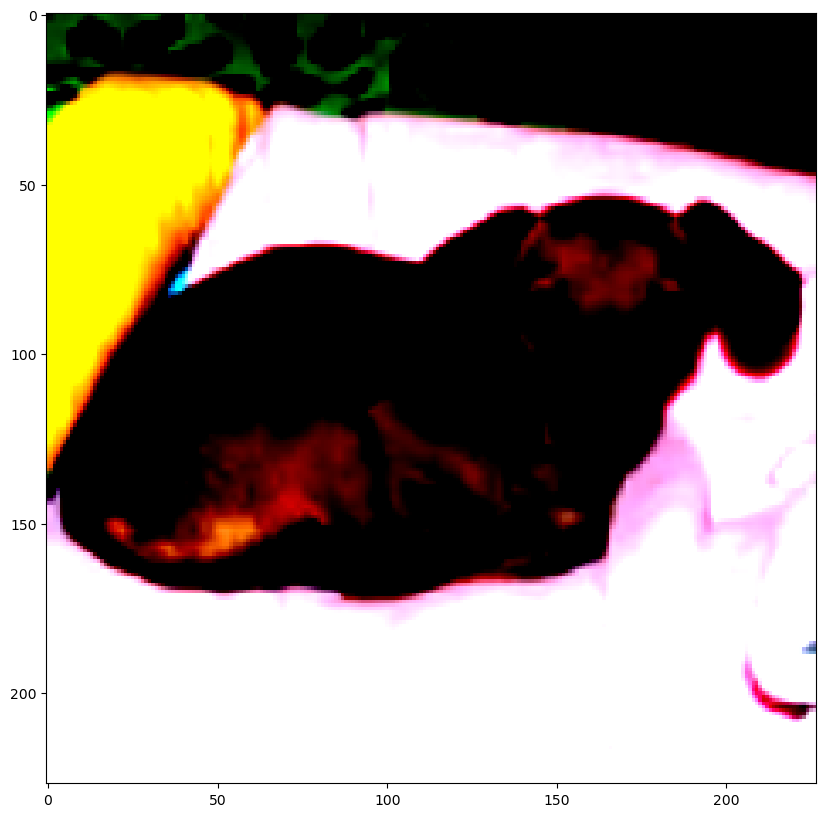

In [9]:
import torch
from torchvision import utils
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

# display the transformed sample images from train_ds

# define helper function to show images
def show(img, y=None, color=True):

    npimg = img.numpy()
    npimg_tr = np.transpose(npimg, (1, 2, 0))
    plt.imshow(npimg_tr)
    
    # plt.imshow(npimg_tr)
    if y is not None:
        plt.title('labels: ' + str(y))

np.random.seed(0)
torch.manual_seed(0)

# pick a random sample image 
rnd_inds = int(np.random.randint(0, len(train_ds), 1))
print(rnd_inds)
img, label = train_ds[rnd_inds]
print('images indices: ', rnd_inds)

plt.figure(figsize=(10, 10))
show(img)

In [10]:
# count the number of images per category in train_ds
import collections
y_train = [y for _, y in train_ds]
counter_train = collections.Counter(y_train)
print(counter_train)

Counter({1: 500, 5: 500, 6: 500, 3: 500, 9: 500, 7: 500, 4: 500, 8: 500, 0: 500, 2: 500})


In [11]:
# split the indices of test0_ds into two groups
# there aren't validation dataset in STL10 dataset, so make validation dataset
# by spliting test0 dataset
from sklearn.model_selection import StratifiedShuffleSplit

# StratifiedShuffleSplit splits indices of test0 in same proportion of labels
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=0)

indices = list(range(len(test0_ds)))
y_test0 = [y for _,y in test0_ds]

for test_index, val_index in sss.split(indices, y_test0):
    print('test :', len(test_index) , 'val :', len(val_index))

test : 6400 val : 1600


In [12]:
# create two datasets from test0_ds
from torch.utils.data import Subset

# if test0_ds is updated, val_ds and test_ds are updated
# because val_ds and test_ds are a subset of test0_ds
val_ds = Subset(test0_ds, val_index)
test_ds = Subset(test0_ds, test_index)

In [13]:
# count the number of images per calss in val_ds and test_ds
import collections
import numpy as np

y_test = [y for _, y in test_ds]
y_val = [y for _, y in val_ds]

counter_test = collections.Counter(y_test)
counter_val = collections.Counter(y_val)
print(counter_test)
print(counter_val)

Counter({6: 640, 0: 640, 4: 640, 5: 640, 9: 640, 2: 640, 3: 640, 1: 640, 7: 640, 8: 640})
Counter({2: 160, 8: 160, 3: 160, 6: 160, 4: 160, 1: 160, 5: 160, 9: 160, 0: 160, 7: 160})


In [14]:
# create dataloaders from train_ds and val_ds
from torch.utils.data import DataLoader

train_dl = DataLoader(train_ds, batch_size=32, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=32, shuffle=False)

# check dataloader
for x,y in train_dl:
    print(x.shape)
    print(y.shape)
    break

for x,y in val_dl:
    print(x.shape)
    print(y.shape)
    break

torch.Size([32, 3, 227, 227])
torch.Size([32])
torch.Size([32, 3, 227, 227])
torch.Size([32])


In [15]:
# define device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [16]:
import torch.nn as nn
import torch.nn.functional as F

class AlexNet(nn.Module):
    def __init__(self, num_classes=10):
        super(AlexNet,self).__init__()
        # input size : (b x 3 x 227 x 227)
        # 논문에는 image 크기가 224 pixel이라고 나와 있지만, 오타입니다.
        # 227x227을 사용합니다.

        # Conv layer
        self.net = nn.Sequential(
            nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=0), # (b x 96 x 55 x 55)
            nn.ReLU(inplace=True),
            nn.LocalResponseNorm(size=5, alpha=0.0001, beta=0.75, k=2),
            nn.MaxPool2d(kernel_size=3, stride=2), # (b x 96 x 27 x 27)

            nn.Conv2d(96, 256, kernel_size=5, stride=1, padding=2), # (b x 256 x 27 x 27)
            nn.ReLU(),
            nn.LocalResponseNorm(size=5, alpha=0.0001, beta=0.75, k=2),
            nn.MaxPool2d(kernel_size=3, stride=2), # (b x 256 x 13 x 13)

            nn.Conv2d(256, 384, 3, 1, 1), # (b x 384 x 13 x 13)
            nn.ReLU(),

            nn.Conv2d(384, 384, 3, 1, 1), # (b x 384 x 13 x 13)
            nn.ReLU(),

            nn.Conv2d(384, 256, 3, 1, 1), # (b x 256 x 13 x 13)
            nn.ReLU(),
            nn.MaxPool2d(3, 2), # (b x 256 x 6 x 6)
        )

        # fc layer
        self.classifier = nn.Sequential(
            nn.Dropout(p=0.5, inplace=True),
            nn.Linear(in_features=(256 * 6 * 6), out_features=4096),
            nn.ReLU(),
            nn.Dropout(p=0.5, inplace=True),
            nn.Linear(in_features=4096, out_features=4096),
            nn.ReLU(),
            nn.Linear(in_features=4096, out_features=num_classes),
        )

        # weight initialization
        self.init_weight()

    # define weight initialization function
    def init_weight(self):
        for layer in self.net:
            if isinstance(layer, nn.Conv2d):
                nn.init.normal_(layer.weight, mean=0, std=0.01)
                nn.init.constant_(layer.bias, 0)
        # in paper, initialize bias to 1 for conv2, 4, 5 layer
        nn.init.constant_(self.net[4].bias, 1)
        nn.init.constant_(self.net[10].bias, 1)
        nn.init.constant_(self.net[12].bias, 1)
    
    def forward(self,x):
        x = self.net(x)
        x = x.view(-1, 256 * 6* 6)
        x = self.classifier(x)
        return x
     

In [17]:

# check the model
model = AlexNet().to(device)
print(model)

AlexNet(
  (net): Sequential(
    (0): Conv2d(3, 96, kernel_size=(11, 11), stride=(4, 4))
    (1): ReLU(inplace=True)
    (2): LocalResponseNorm(5, alpha=0.0001, beta=0.75, k=2)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (5): ReLU()
    (6): LocalResponseNorm(5, alpha=0.0001, beta=0.75, k=2)
    (7): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU()
    (10): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=True)
    (1): Linear(in_features=9216, out_features=4096, bias=True)


In [18]:
# get the model summary
from torchsummary import summary
summary(model, input_size=(3, 227, 227), device=device.type)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 96, 55, 55]          34,944
              ReLU-2           [-1, 96, 55, 55]               0
 LocalResponseNorm-3           [-1, 96, 55, 55]               0
         MaxPool2d-4           [-1, 96, 27, 27]               0
            Conv2d-5          [-1, 256, 27, 27]         614,656
              ReLU-6          [-1, 256, 27, 27]               0
 LocalResponseNorm-7          [-1, 256, 27, 27]               0
         MaxPool2d-8          [-1, 256, 13, 13]               0
            Conv2d-9          [-1, 384, 13, 13]         885,120
             ReLU-10          [-1, 384, 13, 13]               0
           Conv2d-11          [-1, 384, 13, 13]       1,327,488
             ReLU-12          [-1, 384, 13, 13]               0
           Conv2d-13          [-1, 256, 13, 13]         884,992
             ReLU-14          [-1, 256,

In [19]:
# check weight initialization
for p in model.parameters():
    print(p)
    break

Parameter containing:
tensor([[[[ 4.3972e-04,  3.4060e-03,  3.3980e-03,  ...,  1.0186e-02,
            2.1858e-02,  6.5544e-03],
          [-9.8765e-03, -4.6774e-03,  2.2661e-02,  ..., -1.5662e-02,
           -5.3097e-04, -8.0375e-03],
          [ 6.4729e-05, -7.0680e-03,  6.1003e-04,  ..., -7.1808e-05,
            2.3969e-02,  1.5700e-02],
          ...,
          [-7.3427e-03,  3.0550e-03, -1.3856e-02,  ...,  5.5178e-03,
            1.2065e-02,  1.7643e-02],
          [-1.1075e-02,  1.5826e-02,  1.3693e-02,  ...,  1.6379e-02,
           -1.0624e-02,  9.9964e-03],
          [-6.8476e-03,  9.3148e-03, -1.1118e-03,  ..., -5.6986e-03,
           -1.3735e-02, -1.5864e-02]],

         [[ 2.9228e-03,  7.1842e-03,  3.5491e-04,  ..., -2.9287e-03,
           -8.8213e-03,  4.5906e-03],
          [-2.6411e-03, -1.1162e-02, -7.2584e-05,  ..., -1.1122e-02,
           -4.7595e-03, -4.3143e-03],
          [-5.9992e-03,  1.5186e-03, -7.9879e-04,  ..., -4.9238e-04,
            8.6835e-03, -1.7857e-03]

In [20]:
# define the loss function
loss_func = nn.CrossEntropyLoss(reduction='sum')

In [21]:
# define the optimizer
from torch import optim
# opt = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=0.0005)
opt = optim.Adam(model.parameters(), lr=0.01)

In [30]:
# read the current value of the learning rate using the following function
def get_lr(opt):
    for param_group in opt.param_groups:
        return param_group['lr']
        

In [31]:
# define lr_scheduler : 1/10 per 10 epochs
from torch.optim.lr_scheduler import StepLR
lr_scheduler = optim.lr_scheduler.StepLR(opt, step_size=30, gamma=0.1)

In [32]:
# define a function to count the number of correct predictions per mini-batch
def metrics_batch(output, target):
    # get output class
    pred = output.argmax(dim=1, keepdim=True)
    # compare output class with target class
    corrects = pred.eq(target.view_as(pred)).sum().item()
    return corrects

In [33]:
# define a function to compute the loss value per mini-batch
def loss_batch(loss_func, output, target, opt=None):
    loss = loss_func(output, target)

    metric_b = metrics_batch(output, target)
    if opt is not None:
        opt.zero_grad()
        loss.backward()
        opt.step()
    return loss.item(), metric_b

In [34]:
# develop a function to compute the loss value and the performance metric for the epoch
def loss_epoch(model, loss_func, dataset_dl, sanity_check=False, opt=None):
    running_loss = 0
    running_metric = 0
    len_data = len(dataset_dl.dataset)

    for xb, yb in dataset_dl:
        # move batcch to device
        xb = xb.to(device)
        yb = yb.to(device)
        # get model output
        output = model(xb)

        # get loss per batch
        loss_b, metric_b = loss_batch(loss_func, output, yb, opt)

        # update running loss
        running_loss += loss_b
        # update running metric
        if metric_b is not None:
            running_metric += metric_b
        
        # break the loop in case of sanity check
        if sanity_check is True:
            break

    # average loss value and metric value
    loss = running_loss / float(len_data)
    metric = running_metric / float(len_data)
    return loss, metric
     

In [35]:
import time
import copy

# develop train_val function
def train_val(model, params):
    # extract model parameters
    num_epochs = params['num_epochs']
    loss_func = params['loss_func']
    opt = params['optimizer']
    train_dl = params['train_dl']
    val_dl = params['val_dl']
    sanity_check = params['sanity_check']
    lr_scheduler = params['lr_scheduler']
    path2weights = params['path2weights']

    # keep a history of the loss and the metric value
    loss_history = {
        'train': [],
        'val': [],
    }

    metric_history = {
        'train': [],
        'val': [],
    }

    # save the best perfirming model
    best_model_wts = copy.deepcopy(model.state_dict())

    # initializer the best loss to an infinite value
    best_loss = float('inf')

    for epoch in range(num_epochs):
        start_time = time.time()

        # get current learning rate
        current_lr = get_lr(opt)
        print('Epoch {}/{}, current lr={}'.format(epoch, num_epochs-1, current_lr))

        # train model on trainin dataset
        model.train()
        train_loss, train_metric = loss_epoch(model, loss_func, train_dl, sanity_check, opt)

        # collect loss and metric for the training dataset
        loss_history['train'].append(train_loss)
        metric_history['train'].append(train_metric)

        # evaluate model on validation dataset
        model.eval()
        with torch.no_grad():
            val_loss, val_metric = loss_epoch(model, loss_func, val_dl, sanity_check)
        
        # store the best model
        if val_loss < best_loss:
            best_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            # store weights into a local file
            torch.save(model.state_dict(), path2weights)
            print('Copied best model weights')

        # collect loss and metric for validation dataset
        loss_history["val"].append(val_loss)
        metric_history["val"].append(val_metric)

        # update the learning rate
        lr_scheduler.step()
        if current_lr != get_lr(opt):
            print('Loading best model weights!')
            model.load_state_dict(best_model_wts)

        # print the loss and accuracy values and return the trained model
        print('train loss: %.6f, dev loss: %.6f, accuracy: %.2f, time: %.4f s' %(train_loss, val_loss, 100*val_metric, time.time()-start_time))
        print('-'*10)

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, loss_history, metric_history

In [36]:
# define the training parameters
params_train = {
    'num_epochs':3,
    'optimizer':opt,
    'loss_func':loss_func,
    'train_dl':train_dl,
    'val_dl':val_dl,
    'sanity_check':False,
    'lr_scheduler':lr_scheduler,
    'path2weights':'./models/weights.pt',
}

# check the directory to save weights.pt
def createFolder(directory):
    try:
        if not os.path.exists(directory):
            os.makedirs(directory)
    except OSerror:
        print('Error')
createFolder('./models')

In [ ]:
# train model
model, loss_hist, metric_hist = train_val(model, params_train)

In [ ]:
# Train-Validation Progress
num_epochs=params_train["num_epochs"]

# plot loss progress
plt.title("Train-Val Loss")
plt.plot(range(1,num_epochs+1),loss_hist["train"],label="train")
plt.plot(range(1,num_epochs+1),loss_hist["val"],label="val")
plt.ylabel("Loss")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()

# plot accuracy progress
plt.title("Train-Val Accuracy")
plt.plot(range(1,num_epochs+1),metric_hist["train"],label="train")
plt.plot(range(1,num_epochs+1),metric_hist["val"],label="val")
plt.ylabel("Accuracy")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()